# Project: Identify Customer Segments

In this project, We apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

At the end of most sections, there will be a Markdown cell labeled Discussion. In these cells, We report my findings for the completed section, as well as document the decisions made in the approach to each subtask. The project will be evaluated not just on the code used to complete the tasks outlined, but also the communication about observations and conclusions at each stage.



In [148]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, We load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

In [149]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [150]:
# Check the structure of the data after it's loaded 
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [151]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [152]:
feat_info.describe()


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CJT_GESAMTTYP,person,ordinal,[-1]
freq,1,43,49,26


 
## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.



In [153]:
# Identify missing or unknown data values and convert them to NaNs.
number_missing_values = azdias.isnull().sum().sum()
print('Number of naturally missing values is {}'.format(number_missing_values))

Number of naturally missing values is 4896838


In [154]:
start = time.time()

# Remove missing_or_unknown codes from azdias
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
        
end = time.time()        

In [155]:
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after conversion is 8373929


In [156]:
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

Total execution time of this procedure: 38.89 seconds


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [157]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_column =(azdias.isnull().sum()/len(azdias))*100

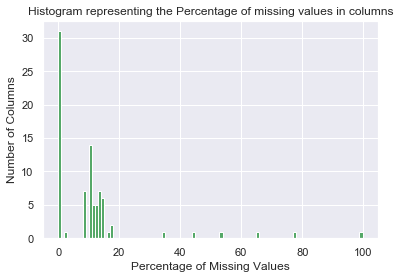

In [158]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing_column, facecolor='g',bins=100)
plt.title('Histogram representing the Percentage of missing values in columns')
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()


In [159]:
# Remove the outlier columns from the dataset. 
filtered = percent_missing_column[percent_missing_column>20]
azdias.drop(filtered.index, axis=1, inplace=True)


In [160]:
print('These columns have more than 20 percent missing data, and it was dropped:{}'.format(filtered))


These columns have more than 20 percent missing data, and it was dropped:AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


#### Discussion 1.1.2: Assess Missing Data in Each Column


 Most of the columns contain less than 20% of the lost data. Therefore, columns with more than 20% of the missing data are considered as outlier columns and are dropped.
 




#### Step 1.1.3: Assess Missing Data in Each Row

Now, We perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, some groups of points have a very different numbers of missing values. We divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We select some of these columns and compare the distribution of values.

- We can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, we can write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on the observation in the comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.

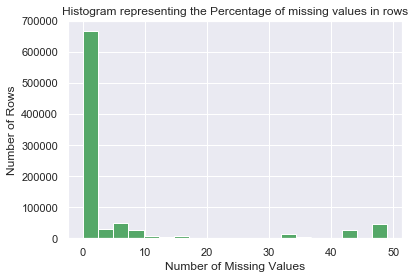

In [161]:
# How much data is missing in each row of the dataset?
percent_missing_row =azdias.isnull().sum(axis=1)
plt.hist(percent_missing_row,facecolor='g', bins=20)
plt.title('Histogram representing the Percentage of missing values in rows')
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [162]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_missing_high = azdias[azdias.isnull().sum(axis=1) >= 30]

rows_missing_low = azdias[azdias.isnull().sum(axis=1) < 30 ]

In [163]:
print('rows with many missing values:', rows_missing_high.shape[0], 'of all data')

rows with many missing values: 93160 of all data


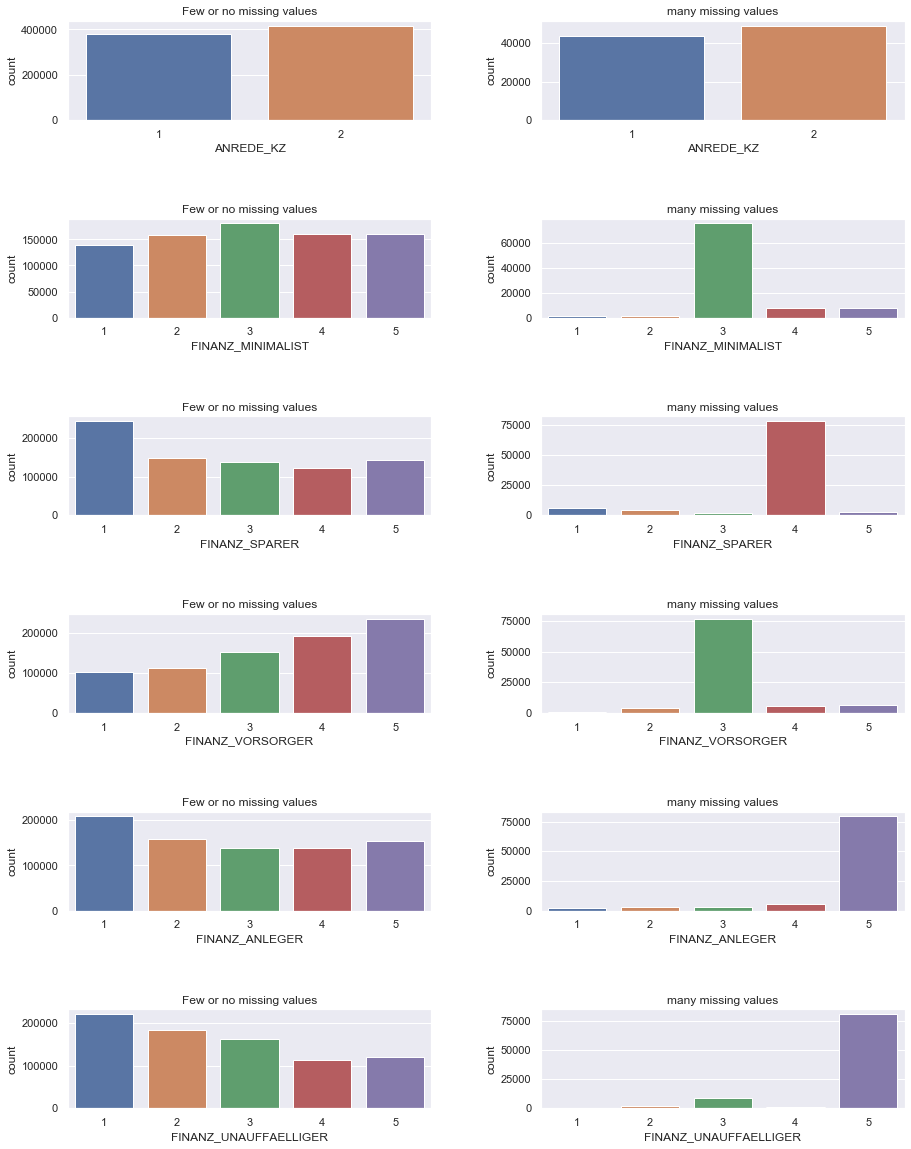

In [164]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

zero_missing_coloumns = percent_missing_column[percent_missing_column==0].index.tolist()
compare_columns = zero_missing_coloumns[:6]


figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
sns.set(style="darkgrid")

for n in range (len(compare_columns))  :
    sns.countplot(rows_missing_low[compare_columns[n]], ax=axs[n][0])
    ax=axs[n][0].set_title('Few or no missing values')
    sns.countplot(rows_missing_high[compare_columns[n]], ax=axs[n][1])
    ax=axs[n][1].set_title('many missing values')


#### Discussion 1.1.3: Assess Missing Data in Each Row

- The dataset was divided between rows with many missing column values (more than 30) and rows with few missing column values.
- From the graphs above, the distributions of the gender values between the two data sets are similar, with most of the population being female.
But other columns have distributions that differ greatly by section. This means that there is a pattern in the way data is lost, so outputting null-valued rows would lead to bias.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.



In [165]:
# How many features are there of each data type
features = list(rows_missing_low.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]

feat_info_clean['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [166]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_clean[feat_info_clean['type'] == 'categorical']['attribute'].values


In [167]:
binary_feature = []
multi_feature = []

for feature in categorical:
    if (len(rows_missing_low[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(rows_missing_low[feature].unique())>2):
        multi_feature.append(feature)

print('Binary features are: {}'.format(binary_feature))
print('Multi-level features are: {}'.format(multi_feature))        

Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [168]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, rows_missing_low[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [1. 0.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [169]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean= rows_missing_low.replace({'OST_WEST_KZ':{'W': 0, 'O': 1}})

for feature in multi_feature:
    azdias_clean=azdias_clean.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

We found four binary features, one of which was non numeric. For this variable (OST_WEST_KZ), We encoded 'W' as 0 and 'O' as 1 to keep it in analysis, And dropped all multi-level features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


We can check `Data_Dictionary.md` for the details needed to finish these tasks.

In [170]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']


decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_clean['DECADE'].replace(decade_dict, inplace=True)
azdias_clean['MOVEMENT'].replace(movement_dict, inplace=True)

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']


wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}


azdias_clean['WEALTH'].replace(wealth_dict, inplace=True)
azdias_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features




 
It kept these two mixed-value features:

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
 
And we engineered these two mixed-value features:
- We created two new feature columns and values copied from the mixed value feature initial column.
- We created two dictionaries to assign the initial feature values to the new feature values.
- Replacement was performed using dictionaries in the new feature columns.
- We decided to drop the other four mixed values features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. The dataframe should consist of the following:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.



In [171]:
mixed = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
for feature in mixed:
    azdias_clean.drop(feature, axis=1, inplace=True)

In [172]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, I make the function below to execute the main feature selection, encoding, and re-engineering steps performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [194]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    # remove selected columns and rows, ...
    # drop columns with more than 20% missing values
    columns_miss_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(columns_miss_20, axis=1)
    # drop rows with more than 3 missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3]
    # select, re-encode, and engineer column values.

    # re-encode binary feature
    df_clean = df_clean.replace({'OST_WEST_KZ':{'W': 0, 'O': 1}})
    
    # drop multi-leve features
    categorical  = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    multi_feature=[]
    for feature in categorical:
        if (len(rows_missing_low[feature].unique())>2):
            multi_feature.append(feature)
    for feature in multi_feature:
        df_clean=df_clean.drop(feature, axis=1)
    
    # engineer mixed features
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    mixed = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    for feature in mixed:
        df_clean.drop(feature, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html)  to help us navigate to all of the classes and functions that we'll need. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, we make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. We might also try a more complicated procedure where we temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the  `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time.

In [174]:
fill_missing = SimpleImputer(strategy='most_frequent')
imputed_features = pd.DataFrame(fill_missing.fit_transform(azdias_clean))

In [175]:
imputed_features.columns = azdias_clean.columns
imputed_features.index = azdias_clean.index

In [176]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_features = scaler.fit_transform(imputed_features)

In [177]:
standardized_features = pd.DataFrame(standardized_features, columns=list(imputed_features))
standardized_features.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,0.442528,1.455847,0.574305,-0.171400,-0.127041,0.684882,1.098070,0.530409,1.175657,-1.248894
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.934798,0.419740,0.574305,-0.171400,-0.127041,-0.789027,1.098070,-1.885336,-0.869680,0.767095
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.934798,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,-0.267778,0.530409,-1.551459,-0.576897
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,0.442528,-0.616366,-0.337195,0.830348,0.308213,1.421837,-0.267778,0.530409,0.493878,0.095099
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,0.442528,1.455847,1.485805,-1.173149,-0.997549,-0.052072,-1.633627,0.530409,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

- The nan was imputed using the Mode (most frequent) value per column. The Mode was chosen, instead of the mean, because it is more robust against outliers, using the SimpleImputer method. 
- The features were standardized using StandardScaler to achieve a mean of 0 and a standard deviation of 1.
[Reference](https://scikit-learn.org/stable/modules/impute.html)

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques.

- We use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- We check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I plot the cumulative / sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. I select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, we re-fit a PCA instance to perform the decided-on transformation.


In [178]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit(standardized_features)

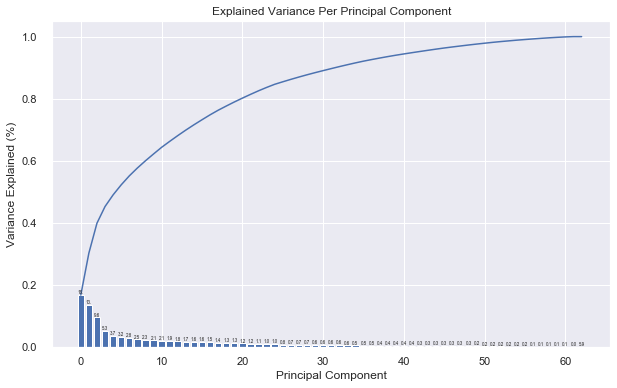

In [179]:
 def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [180]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35 = PCA(n_components = 35)
pca_features = pca_35.fit_transform(standardized_features)

### Discussion 2.2: Perform Dimensionality Reduction

After looking at the variance explained by each component in a scree plot, I decided to retain 35 principal components, as it explains more than 90% of variances.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. I use the data dictionary document to understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I write a function that can be called at any time to print the sorted list of feature weights, for the i-th principal component.

In [181]:
def plot_pca(data, pca, n_components):
    '''
Plot the features with the most absolute variance for given pca component 
'''
    components = pd.DataFrame(np.round(pca.components_, 3), columns = data.keys()).iloc[n_components-1]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(5), components.tail(5)])
    
    components.plot(kind='bar', title='Component ' + str(n_components))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

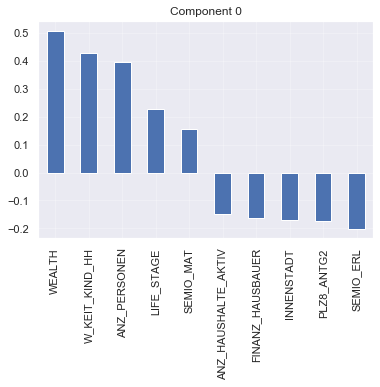

In [182]:
plot_pca(standardized_features, pca_35, 0)


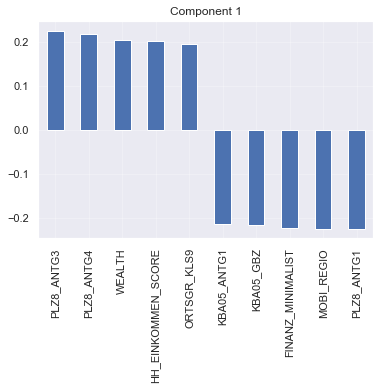

In [184]:
plot_pca(standardized_features, pca_35, 1)


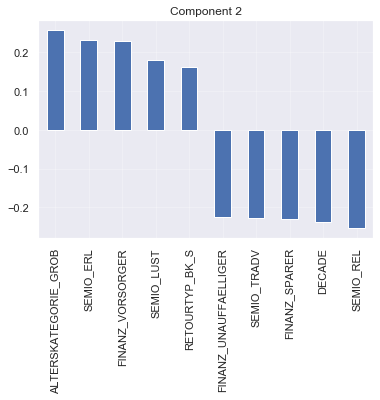

In [185]:
plot_pca(standardized_features, pca_35, 2)


### Discussion 2.3: Interpret Principal Components



* ##### The first principal componen :
has a positive association with (Personality typology)
> SEMIO_MAT(materialistic), W_KEIT_KIND_HH(Likelihood of children in household ), ANZ_PERSONEN(Number of adults in household)

* ##### The second principal componen :
has a positive association with 
> PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region),PLZ8_ANTG3
(Number of 6-10 family houses in the PLZ8 region),HH_EINKOMMEN_SCORE
(Estimated household net income),ORTSGR_KLS9(Size of community) .

* ##### The third principal componen :
has a positive association with 
> ALTERSKATEGORIE_GROB(Estimated age based on given name analysis),FINANZ_VORSORGER(Financial typology),SEMIO_LUST(sensual-minded),RETOURTYP_BK_S(Return type) and SEMIO_REL(event-oriented).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, We apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, We compute the average difference from each point to its assigned cluster's center.
- We perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We use this fact to select a final number of clusters in which to group the data.
- Once a final number of clusters has been selected for use, We re-fit a KMeans instance to perform the clustering operation. We also obtain the cluster assignments for the general demographics data.

In [187]:
def kmean_score(data, n_cluster):
    
    # instantiate kmeans
    kmeans = KMeans(n_clusters = n_cluster)
    # fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [188]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

start_time = time.time()

scores = []
centers = list(range(1,11))
for center in centers:
    scores.append(kmean_score(pca_features, center )) 
    
End_time = time.time()    

In [189]:
print("--- Run time: %s mins ---" % np.round(((End_time - start_time)/60),2))

--- Run time: 18.86 mins ---


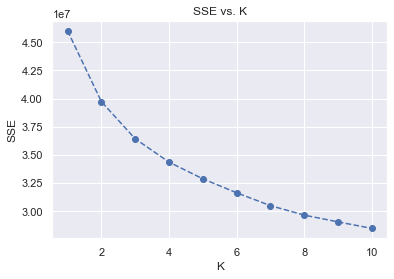

In [190]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [191]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=8)
kmeans_model = kmeans.fit(pca_features)
predict = kmeans_model.predict(pca_features)


### Discussion 3.1: Apply Clustering to General Population

From the above plot, we can see that the score keeps decreasing and there is no obvious elbow. However, the rate of change of slope starts to decrease at 8 so we decided to use it for this problem and to move forward with 8 clusters.


### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We should not confuse this for re-fitting all of the models to the customer data. Instead, We use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, We interpret how the general population fits apply to the customer data.

- We apply the same feature wrangling, selection, and engineering steps to the customer demographics using the  `clean_data()`unction We created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- We use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a .fit() or .fit_transform() method to re-fit the old objects, nor should we be creating new sklearn objects! We should carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [192]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [193]:
customers

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [203]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

In [196]:
customers_clean_imputed = pd.DataFrame(fill_missing.fit_transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

In [197]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
customers_clean_scaled = scaler.fit_transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))

In [198]:
# transform the customers data using pca object
customers_pca = pca_35.transform(customers_clean_scaled)

In [199]:
# predict clustering using the kmeans object
predict_customers = kmeans_model.predict(customers_pca)

-----------------------------------------------------

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, We compare the two cluster distributions to see where the strongest customer base for the company is.

We consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In this step:

- We compute the proportion of data points in each cluster for the general population and the customer data. Visualizations are useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis we performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values.
  
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? We select one such cluster and infer what kind of people might be represented by that cluster. We use the principal component interpretations from step 2.3 and look at additional components to help make this inference. We can use the `.inverse_transform()`method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- We perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

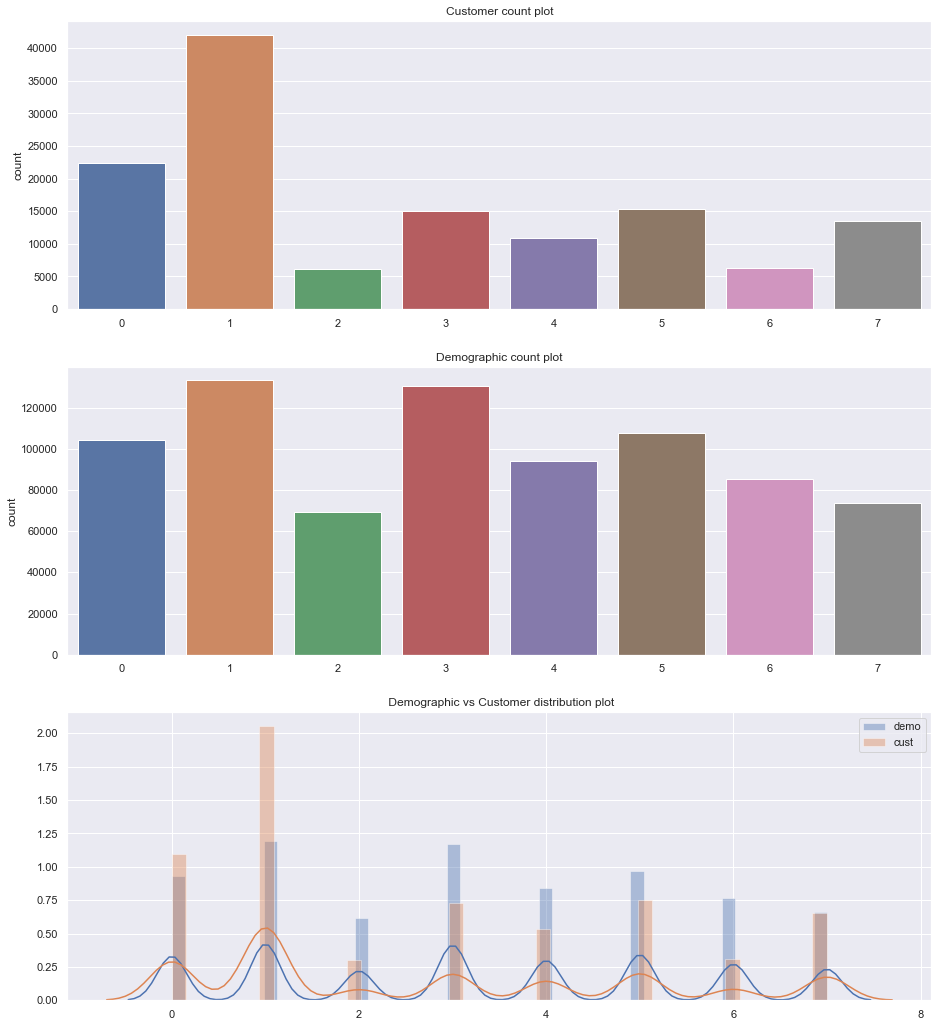

In [200]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title=' Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(predict, label='demo',ax=ax)
sns.distplot(predict_customers, label='cust', ax=ax)
sns.countplot(predict, label='demo', ax=ax2)
sns.countplot(predict_customers, label='cust', ax=ax3)
ax.legend();

In [201]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster center specs can be found below:
specs = pd.DataFrame(scaler.inverse_transform(pca_35.inverse_transform(kmeans.cluster_centers_)), columns=customers_clean.columns)
specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.940160,0.874377,4.502948,0.981473,5.049290,0.737101,1.183550,3.185411,0.363705,2.100943,...,0.950514,3.762630,3.128682,3.294332,6.390293,3.533274,2.030102,0.630183,3.534438,2.943045
1,3.917673,0.912341,5.479368,0.789067,5.091934,0.906524,1.302247,1.778277,0.707592,1.900016,...,0.152889,3.498193,4.071889,2.440395,3.985116,2.361639,2.035688,0.286390,1.638549,3.850582
2,2.840558,0.812552,3.409893,2.308785,3.802475,2.063688,2.546046,3.223577,0.386524,2.115988,...,1.075561,3.778505,2.976635,3.355717,6.698335,3.590812,4.040422,0.607371,3.727155,2.590697
3,4.012040,1.717313,4.890249,0.852414,5.038783,1.369250,1.396180,2.326997,0.723205,1.773614,...,0.155508,3.495810,4.068367,2.429338,3.994447,2.356363,2.112659,0.270782,1.738241,3.900891
4,2.820019,1.749172,3.737199,2.086709,3.915633,2.630574,2.636160,2.510193,0.487853,2.054401,...,0.162300,3.557959,4.094379,2.403971,3.893398,2.318510,3.990073,0.506070,1.846500,3.658494
5,4.074828,1.765979,3.862959,0.962014,5.099507,1.195223,1.195539,3.898293,0.327942,1.670017,...,0.930712,3.755555,3.152337,3.247625,6.264322,3.502560,1.949624,0.665937,3.538653,3.220050
6,2.694083,1.778458,2.887780,2.261858,3.862730,2.449834,2.495850,3.752122,0.290076,2.037000,...,1.060922,3.787973,3.008851,3.341719,6.735368,3.603481,3.998702,0.703792,3.604496,2.631330
7,2.891844,0.832675,4.312738,2.095737,3.877923,2.202009,2.694583,1.899224,0.627713,1.898939,...,0.170655,3.543058,4.061368,2.439937,3.964768,2.388537,3.983288,0.366247,1.882443,3.689046


### Discussion 3.3: Compare Customer Data to Demographics Data
- Looking at the results above, we can clearly see that for most groups there is a good match between the general population and the total customers. Therefore, a company can use this information to identify a portion of the general population for their business.
- We have to take into account the fact that we have removed some of the columns that have mixed and categorical features, and that contains very important information.
- Also, I would say if we keep these features, we will see a better match between the general population and the total of customers.
